# If there's no asparagus in Innopolis...

When you find something that you like - whether it is a poem, song, or image, it's often useful to have an option to find similar items, such that you can enjoy songs of the same kind, for example. For this there exist **recommender systems**, and we will build one today. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have good asparagus in Innopolis?

The recommender system will be based on the vector-space model + dimensionality reduction + cosine similarity measure.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Reading dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/ml/nutrition.csv

In [2]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
dimensions = dataset.columns[1:]

print("Names:", *names[:5], "...", sep=" | ")
print()
print("Classes:", *set(classes_list), sep=" | ")
print()
print("Dimensions:", *dimensions[:5], "...", sep=" | ")

dataset.head()

Names: | Asparagus, 5 spears (93 g/3.3 oz) | Bell Pepper, 1 medium (148 g/5.3 oz) | Broccoli, 1 medium stalk (148 g/5.3 oz) | Carrot, 1 carrot, 7" long, 1 1/4" diameter (78 g/2.8 oz) | Cauliflower, 1/6 medium head (99 g/3.5 oz) | ...

Classes: | Seafood, Serving Size (84 g/3 oz) | Fruits Serving Size (gram weight/ounce weight) | Vegetables, Serving Size (gram weight/ ounce weight)

Dimensions: | Calories | Calories from Fat | Total Fat 1 | Total Fat 2 | Sodium 1 | ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## Assigning colors each food item
Building a `color_list` which attributes a color to each item.

In [3]:
classes = list(set(classes_list))
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
print(class_colors)
color_list = [class_colors[a] for a in classes_list]

{'Seafood, Serving Size (84 g/3 oz)': 'red', 'Fruits Serving Size (gram weight/ounce weight)': 'green', 'Vegetables, Serving Size (gram weight/ ounce weight)': 'blue'}


## Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [4]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X, Y, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
    
def show_points_3d(X, Y, Z):
    global color_list
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## Data Visualization
`A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 fearures). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw values, columns are objects (61, 22)


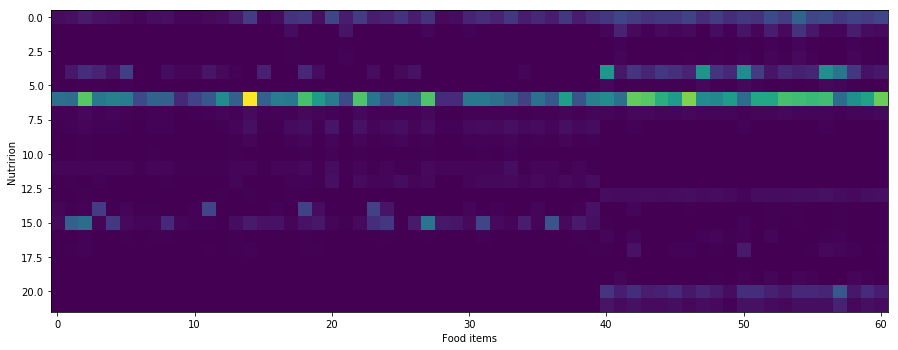

2 random dimensions distribution


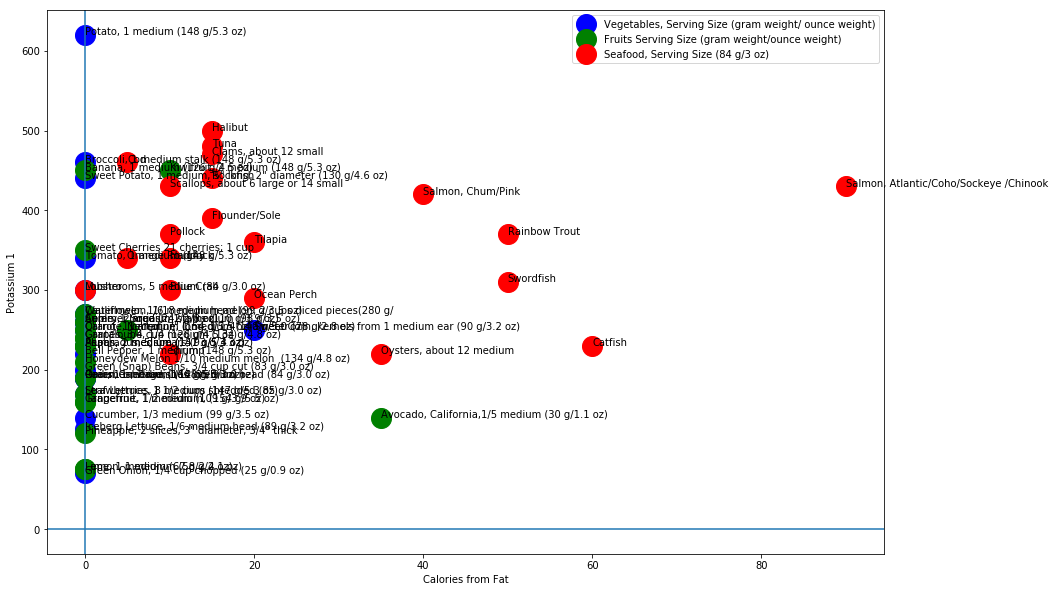

In [5]:
A = np.array(dataset.values[1:,1:-1].astype(float))
print("Raw values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutririon")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## Dimensionality reduction with Principal Components Analysis
Principal components are the dimensions, which express the difference in the dataset in the best way. The variance is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's keep 3 principal components. Fill in the code to apply PCA to our data.

In [6]:
k = 3
#TODO apply PCA to matrix A, and save the results to Ak
Ak = None
Ak.shape

(61, 3)

Check how much variance is explained by the first components

In [7]:
#TODO print ratios of variance explained by the first 3 components

[0.56816006 0.24450404 0.09653148]


Now let's visualize the data after transformation applied

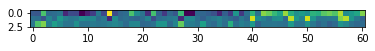

2 first dimensions


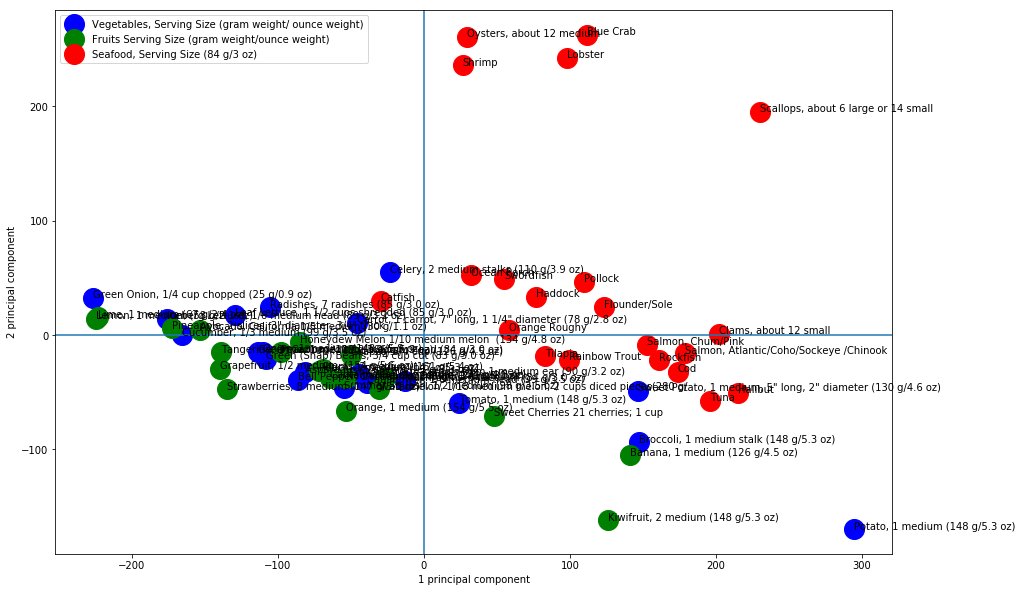

3 first dimensions


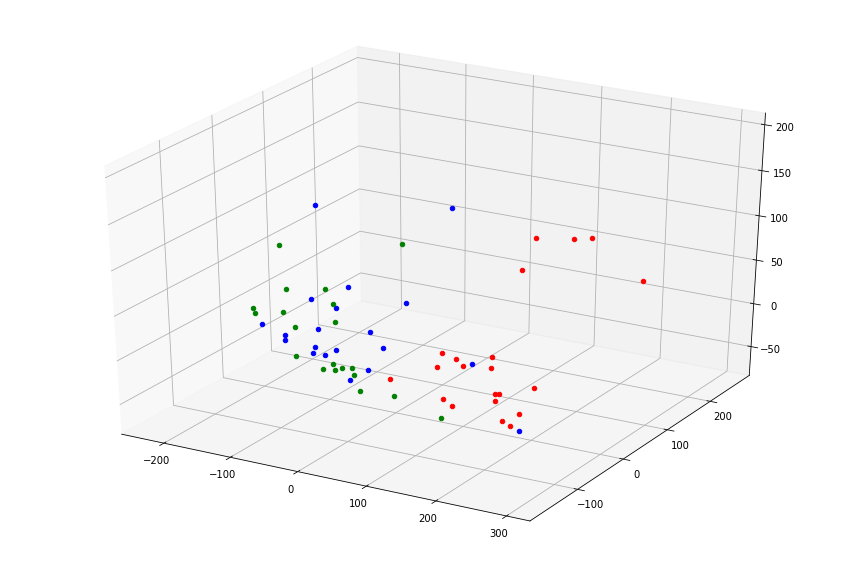

In [8]:
plt.imshow(Ak.T)
plt.show()

print("2 first dimensions")
show_points_2d(Ak.T[0], Ak.T[1], "1 principal component", "2 principal component")
print("3 first dimensions")
show_points_3d(Ak.T[0], Ak.T[1], Ak.T[2])

## Norming
It can happen, that some food is more "condenced" than the others. See, how different celery and popatos in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ norm to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same". Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

2 first dimensions


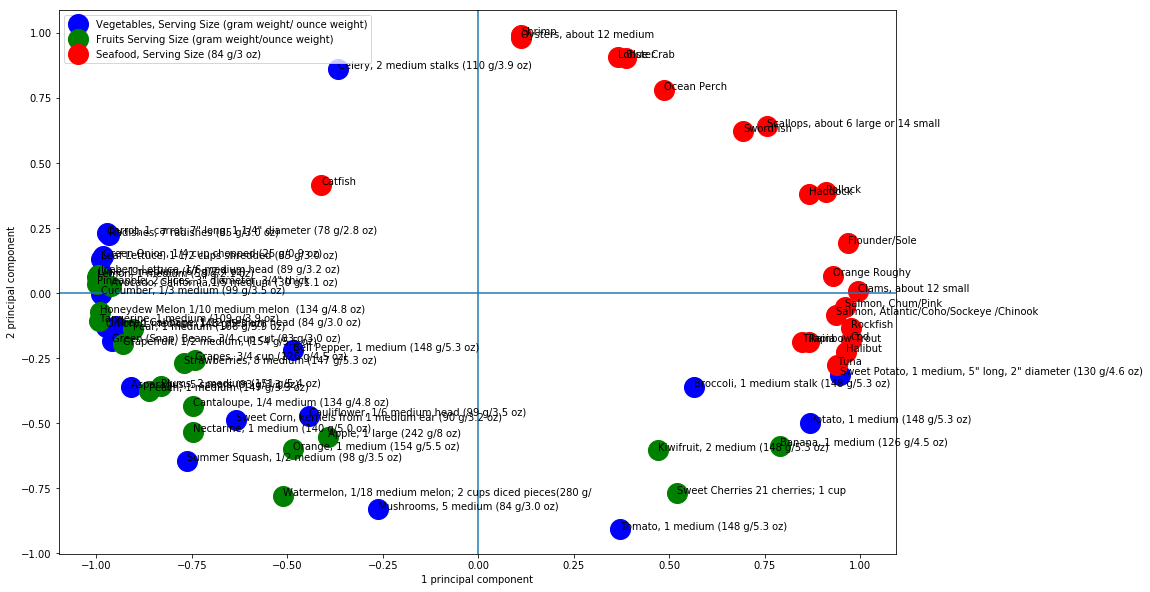

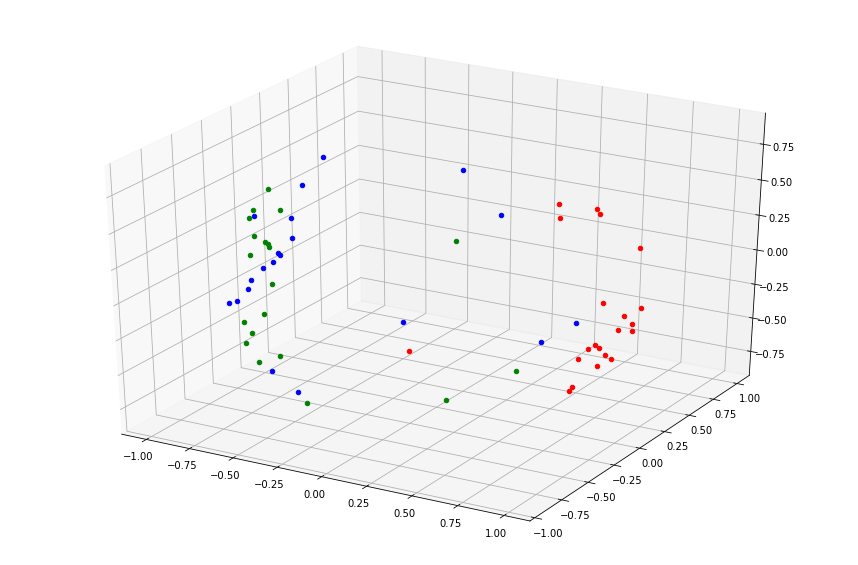

In [9]:
def norm_vectors(A):
    An = A.copy()
    #TODO write here a code that will norm each vector, 
    # i.e. will divide each row of A by its norm ||A[i]||
    return An
    
An = norm_vectors(Ak)

print("2 first dimensions")
show_points_2d(An.T[0], An.T[1], "1 principal component", "2 principal component")
show_points_3d(An.T[0], An.T[1], An.T[2])

## Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend closest food items in terms of nutrition. Please, write the code that will return $k$ closest food items to the provided query vector.

In [10]:
def find_k_closest(query, dataset, k=5):    
    #TODO write here the code that will find 5 closest rows in dataset in terms of cosine similarity
    #HINT: as vectors in dataset are already normed, cosine similarity is just dot product.    
    return []


recommend_to = 0
r = find_k_closest(An[recommend_to,:], An)


print("For:", names[recommend_to])
for k, v, p in r:
    if recommend_to != k: # exclude itself 
        print("\t", names[k], "sim=", p)

For: Asparagus, 5 spears (93 g/3.3 oz)
	 Peach, 1 medium (147 g/5.3 oz) sim= 0.9900283653158954
	 Green (Snap) Beans, 3/4 cup cut (83 g/3.0 oz) sim= 0.9830941138165038
	 Plums, 2 medium (151 g/5.4 oz) sim= 0.9740221818979777
	 Onion, 1 medium (148 g/5.3 oz) sim= 0.9705733085993271


## 2. Try this on text data

Now, it's time to check how well does this work for text data. 
1. Load the inverted index you built last lab with other files needed for the task; 
2. Using these files, build Term-Document Matrix, where each row is a document, and each column is a term, and at the intersection there's a TF-IDF value;
3. Apply the same procedure as above (PCA transform + normalization). Check the amount of variance explained;
4. For a given article (print its url) show urls of the closest articles using cosine similarity;
5. Similarly, show urls of closest articles to a short query, such as "last grammy award".

Display cosine similarity for all search results along with urls.

In [ ]:
#TODO provide your solution for text data

